# validating tsinfer/tsdate tree sequence inference. 
## test 1: contemporaneous tips + recombination

This notebook is a continuation of present.ipynb. Here, I perform topological inference (tsinfer) and internal node dating (tsdate) using the proxy method and varying parameters: recombination_rate AND mismatch_ratio. I plot the relationship between chosen parameter values and number of infered trees. I perform multivariate logistic regression to validate whether the inferred tree sequences are accurately dated. 

### import modules

In [1]:
import tsinfer
import tskit
import msprime
import tsdate
import numpy as np
import pandas as pd
import datetime as dt
import time
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.linear_model import LinearRegression
from itertools import combinations
import seaborn as sns

### simulate ancestry
I use msprime to simulate a geneology of 25 individuals sampled contemporaneously at time = 0 with a fixed recombination rate. 

In [2]:
ts = msprime.sim_ancestry(
    samples = [
        msprime.SampleSet(25, time=0, ploidy = 1),
        #msprime.SampleSet(10, time=10, ploidy = 1),
        #msprime.SampleSet(5, time=50, ploidy = 1)
    ],
    ploidy = 1, 
    sequence_length=1e6,
    random_seed=50,
    recombination_rate=1e-6
)

### simulate mutations onto geneology 
I set a mutation rate onto the geneology. (Note: if I apply too low of a mutation rate, sampled genomes end up being too similar and tsinfer fails to reconstruct topology accurately.) 

In [3]:
ts = msprime.sim_mutations(ts, rate = 3e-5, random_seed = 42) 

The final simulated tree sequence contains 6 trees (i.e. 5 recombination breakpoints) and 256 mutations. 

In [4]:
ts

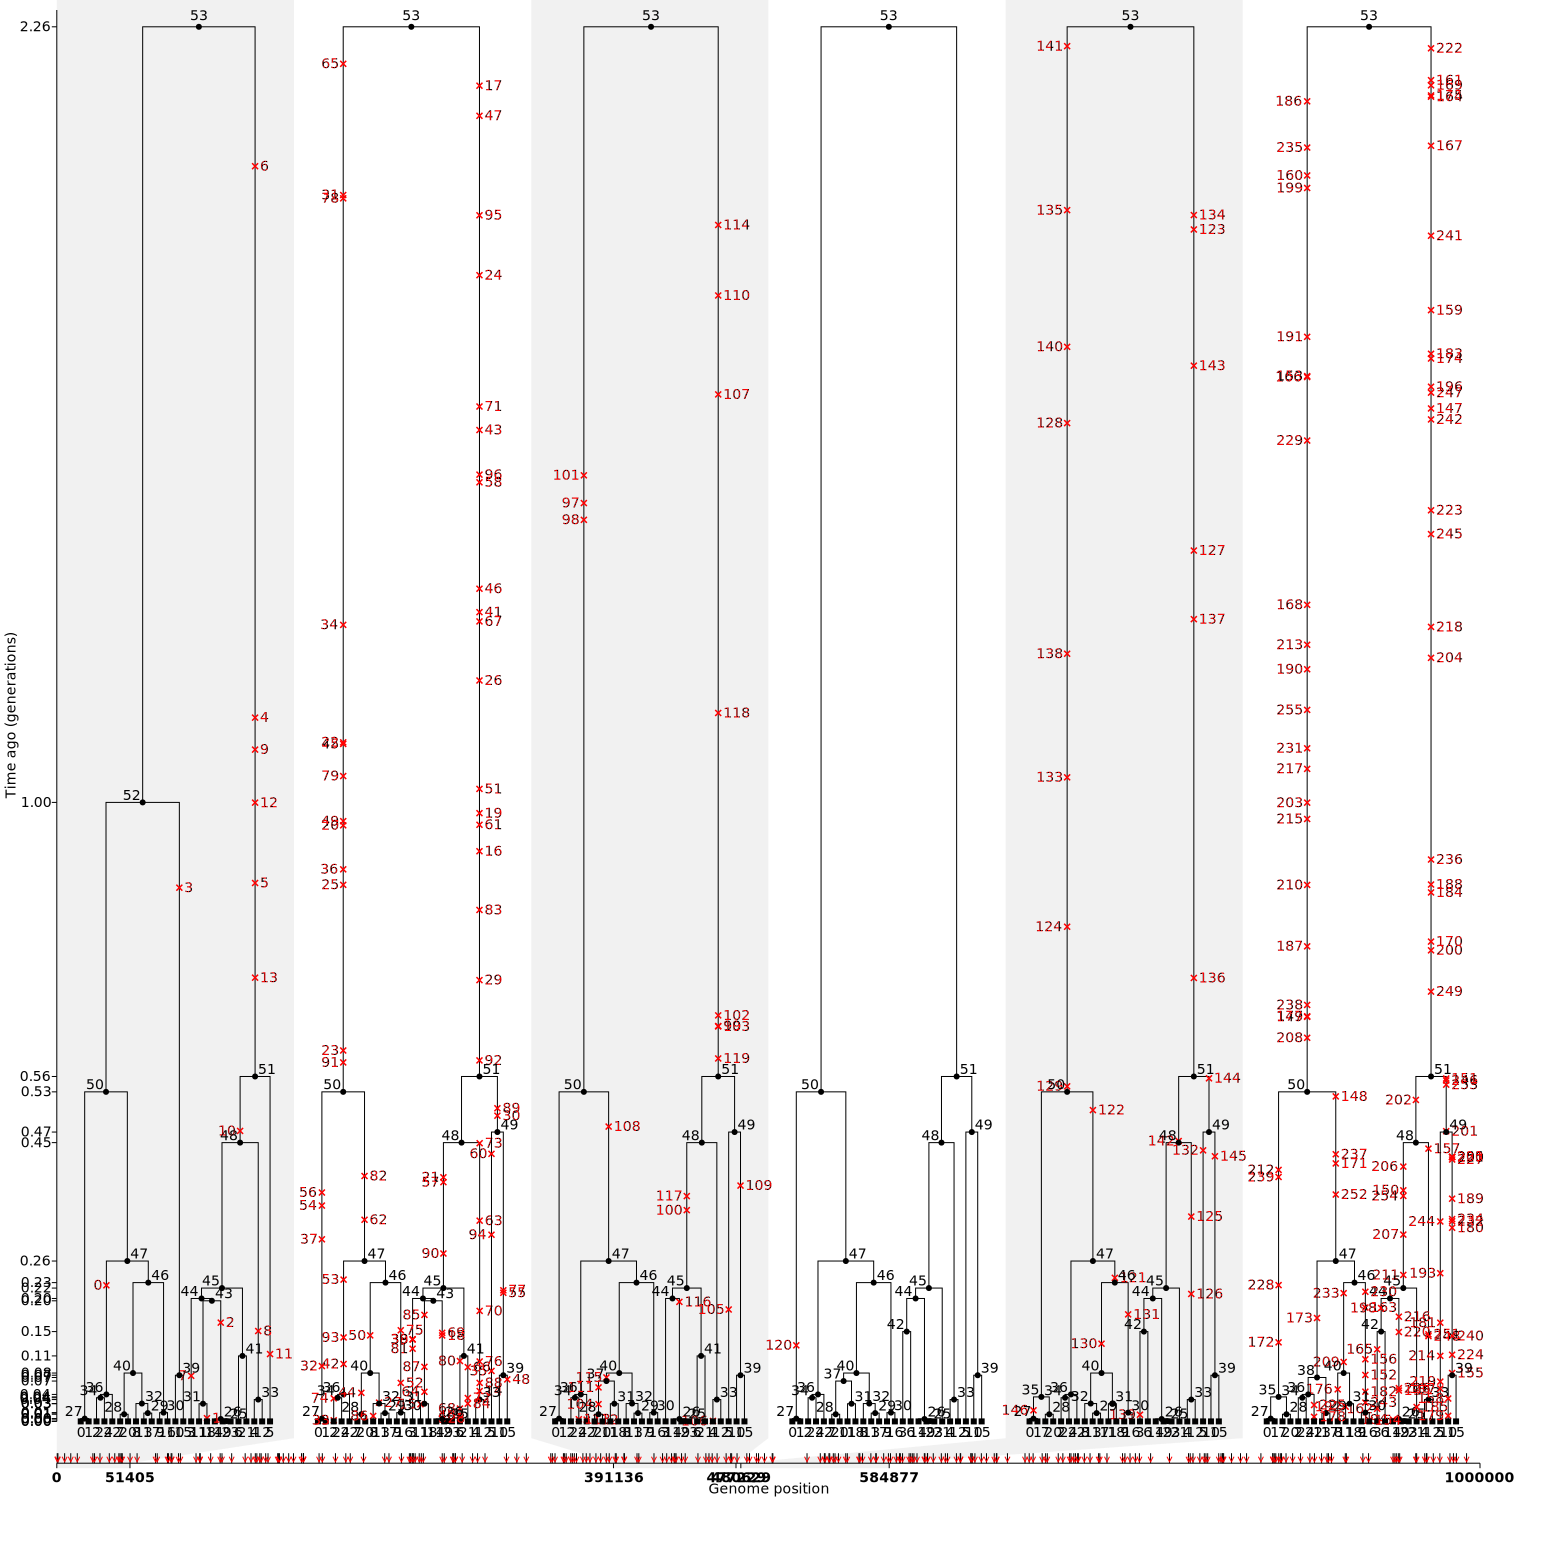

In [5]:
ts.draw_svg(size=(1500, 1500),
 canvas_size=(1550, 1550),
         y_axis=True
        )

### date internal nodes of simulated tree sequence

In [6]:
sampling_times = ts.nodes_time[0:25]

In [7]:
dated_ts = tsdate.date(ts, 
                       mutation_rate=3e-5, # same mutation rate used for simulation 
                       time_units="years", 
                       #return_fit=True,
                       match_segregating_sites = True
                       )



In [8]:
# integer value assigned to each individual in the tree. used for indexing purposes later on. 
samples = list(dated_ts.samples())

### export as vcf and import as vcz
Tsinfer can only read in VCZ files. I export the geneology as a VCF, translate to VCZ (bio2zarr), then reimport.

In [9]:
# with open(f"../data/present_sim.vcf", "w") as fh: 
#     ts.write_vcf(output = fh)

In [10]:
# get ancestral states
ancestral_states = []

for site in ts.sites():
    if site.ancestral_state is None:
        ancestral_states.append("N")
        #print("N")
    else:
        ancestral_states.append(str(site.ancestral_state))
        #print(site.ancestral_state)

ancestral_states = np.array(ancestral_states)

Creating vdata object 

In [11]:
vdata = tsinfer.VariantData("../data/vcz_files/present.vcz", 
                            ancestral_state=ancestral_states,
                           individuals_time=sampling_times)

## run inference
Reinfers the topological/temporal structure of the simulated tree sequences under varying rr (recombination rate) and mm (mismatch ratio). Called by rr_mm() and rr() functions. Returns rr and mm value used to produce tree sequence, as well as the dated simulated tree sequence. 

In [12]:
def run_inference2(vdata, rr_value = None, mm_value = None): 
    
    if rr_value != None:
        rr = rr_value 
        mm = mm_value
    else: 
        rr = None
        mm = None
        

    anc = tsinfer.generate_ancestors(vdata)
    anc_ts = tsinfer.match_ancestors(vdata, anc, recombination_rate = rr, mismatch_ratio = mm)
    ts = tsinfer.match_samples(vdata, anc_ts, recombination_rate = rr)
    simplified_ts = tsdate.preprocess_ts(ts, erase_flanks=False)

    dated_ts = tsdate.date(simplified_ts, 
                       mutation_rate=3e-5, 
                       time_units="years", 
                       #return_fit=True,
                       match_segregating_sites = True,
                       #rescaling_intervals = 492
                       )
    
    return rr, mm, dated_ts
     

### get tree width

In [13]:
def get_intervals(dated_ts): 

    data = []
    
    for tree in dated_ts.trees():
        left, right = tree.interval
        data.append({
            "tree_index": tree.index,
            "left": left,
            "right": right,
        })
    
    intervals = pd.DataFrame(data)

    return intervals


### get mrcas

Returns a dataframe of pairwise MRCAs for every combination of samples, for each tree within the simulated tree sequence.

In [14]:
def sims_times(dated_ts, samples):
    res = []

    for a, b in combinations(samples, 2):
        for i in range(0, dated_ts.get_num_trees()):
            t = dated_ts.at_index(i).tmrca(a, b)
            w = dated_ts.at_index(i).interval.right - dated_ts.at_index(i).interval.left
            l = dated_ts.at_index(i).interval.left
            r = dated_ts.at_index(i).interval.right
            res.append({"index": i, "sample_a": a, "sample_b": b, "mrca": t, "width": w, "left": l, "right": r})
            
    mrcas = pd.DataFrame(res) 
    return mrcas

Returns a dataframe of pairwise MRCAs for every combination of samples, for each tree within the inferred tree sequence.

In [15]:
def res_times(dated_ts, samples):
    res = []

    for a, b in combinations(samples, 2):
        for i in range(1, dated_ts.get_num_trees()-1): #flanking trees are not informative and must be trimmed
            t = dated_ts.at_index(i).tmrca(a, b)
            w = dated_ts.at_index(i).interval.right - dated_ts.at_index(i).interval.left
            l = dated_ts.at_index(i).interval.left
            r = dated_ts.at_index(i).interval.right
            res.append({"index": i, "sample_a": a, "sample_b": b, "mrca": t, "width": w, "left": l, "right": r})
            
    mrcas = pd.DataFrame(res) 
    return mrcas

In [16]:
# def lg(mrcas):
#     X = mrcas["proxy"].values.reshape(-1, 1)
#     y = mrcas["sim"].values
#     weights = mrcas["width"]/1e6
#     reg = LinearRegression().fit(X, y, weights)
#     return X, y, reg, weights


### varying recombination rate and mismatch_ratio during inference

Produces an array of recombination rates and mismatch ratios , then calls run_inference to infer tree sequences under varying parameters. Returns counts (for indexing), metadata (tree index, rr and mm values), and seqs(a list of tree sequences). 

In [17]:
def rr_mm(vdata): 
    
    rates = [10**x for x in range(-8, 0, 1)]
    rates.append(None)

    mms = [10**x for x in range(-3, 1, 1)]
    mms.append(None) 
    
    grid_num_trees = np.zeros(shape=(11, 5))
    seqs = [] #save each ts here 
    
    count = 0
    nones = 0

    metadata = [] 
    counts = []
    for rr_idx, rr_value in enumerate(rates):
        for mm_idx, mm_value in enumerate(mms): 

            if nones > 0: 
                break

            if rr_value == None:
                mm_value = None
                nones += 1 
            
            count+=1
            
            rr, mm, ip = run_inference2(vdata, rr_value, mm_value)
            
            grid_num_trees[rr_idx][mm_idx] = ip.num_trees
            
            seqs.append(ip) 

            metadata.append({"index": count-1, "rate": rr, "mm": mm})

            counts.append({"rate": rr, "mm": mm, "num_trees": ip.num_trees}) 

            print(f"Finished inference {count}/{len(rates)}. RR: {rr_value}, MM: {mm_value}, num trees: {ip.num_trees}")

    return pd.DataFrame(counts), pd.DataFrame(metadata), seqs 


### run inference

Here, I run rr_mm which produces N tree sequences with varying numbers of recombination breakpoints. 

In [18]:
counts, metadata, seqs = rr_mm(vdata)

Finished inference 1/9. RR: 1e-08, MM: 0.001, num trees: 11
Finished inference 2/9. RR: 1e-08, MM: 0.01, num trees: 11
Finished inference 3/9. RR: 1e-08, MM: 0.1, num trees: 11
Finished inference 4/9. RR: 1e-08, MM: 1, num trees: 8
Finished inference 5/9. RR: 1e-08, MM: None, num trees: 8
Finished inference 6/9. RR: 1e-07, MM: 0.001, num trees: 11
Finished inference 7/9. RR: 1e-07, MM: 0.01, num trees: 11
Finished inference 8/9. RR: 1e-07, MM: 0.1, num trees: 11
Finished inference 9/9. RR: 1e-07, MM: 1, num trees: 8
Finished inference 10/9. RR: 1e-07, MM: None, num trees: 8
Finished inference 11/9. RR: 1e-06, MM: 0.001, num trees: 11
Finished inference 12/9. RR: 1e-06, MM: 0.01, num trees: 11
Finished inference 13/9. RR: 1e-06, MM: 0.1, num trees: 11
Finished inference 14/9. RR: 1e-06, MM: 1, num trees: 8
Finished inference 15/9. RR: 1e-06, MM: None, num trees: 8
Finished inference 16/9. RR: 1e-05, MM: 0.001, num trees: 11
Finished inference 17/9. RR: 1e-05, MM: 0.01, num trees: 11
Fin

#### get mrca dfs for simulated tree

In [19]:
rates = [10**x for x in range(-8, 0, 1)]
rates.append("None")

In [20]:
sim_list = sims_times(dated_ts, samples) 

#### get mrca dfs for each tree (w/ varying mm)

In [21]:
rates = [10**x for x in range(-8, 0, 1)]
rates.append("None")

In [22]:
mms = [10**x for x in range(-3, 1, 1)]
mms.append(None)

In [23]:
res_list = []

for id, ts in enumerate(seqs): 
    df = res_times(ts, samples)
    df['rr'] = str(metadata[metadata.index==id].rate.iloc[0]) ###  
    df['mm'] = str(metadata[metadata.index==id].mm.iloc[0]) #### 
    res_list.append(df) 

# Analysis

## plot relationship between parameter value choice (rr, mm) and number of inferred trees

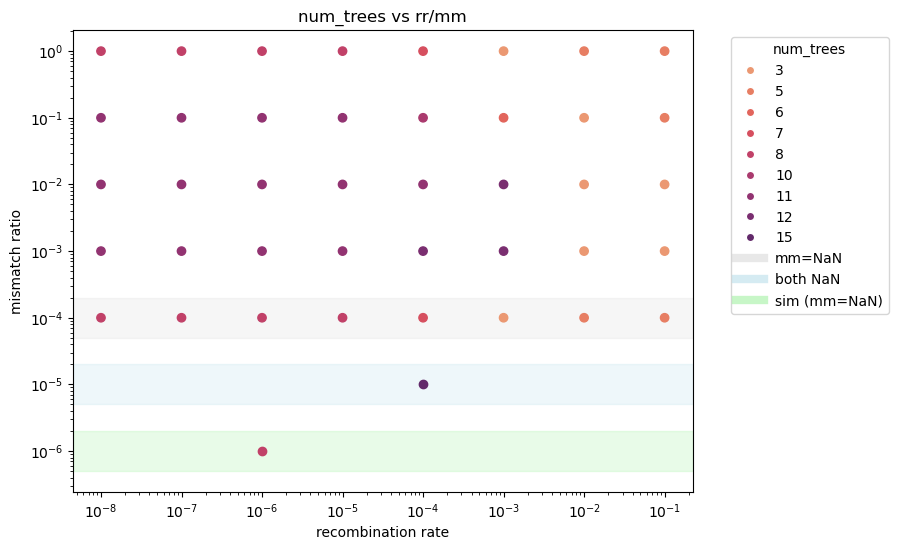

In [25]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

plt.figure(figsize=(8, 6))

# color palette by num_trees
widths = np.sort(counts["num_trees"].unique())
palette = sns.color_palette("flare", n_colors=len(widths))
color_map = dict(zip(widths, palette))
counts["color"] = counts["num_trees"].map(color_map)

# group by NaN type 
valid = counts.dropna(subset=["rate", "mm"])
only_rate_nan = counts[counts["rate"].isna() & counts["mm"].notna()]
only_mm_nan = counts[counts["mm"].isna() & counts["rate"].notna()]
both_nan = counts[counts["rate"].isna() & counts["mm"].isna()]

# fake values for points with NaN params 
dummy_x = 1e-4
dummy_y = 1e-4
offset_y_for_both_nan = 1e-5  # visually distinct

# background strip to highlight NaN/sims
strip_ymin = 5e-5
strip_ymax = 2e-4

# fake values for sim 
sim_rate = 1e-6
sim_mm = 1e-6  # fake value, mm= NaN
sim_num_trees = 8
sim_color = color_map[sim_num_trees]

sim_ymin = 5e-7
sim_ymax = 2e-6


plt.axhspan(ymin=strip_ymin, ymax=strip_ymax, xmin=0, xmax=1,
            color='lightgray', alpha=0.2, zorder=0)

plt.axhspan(ymin=strip_ymin*.1, ymax=strip_ymax*.1, xmin=0, xmax=1,
            color='lightblue', alpha=0.2, zorder=0)

plt.axhspan(ymin=sim_ymin, ymax=sim_ymax, xmin=0, xmax=1,
            color='lightgreen', alpha=0.2, zorder=0)

# plot points
plt.scatter(valid["rate"], valid["mm"], #alpha=0.5, 
            color=valid["color"], label="Valid", zorder=2)

# plot points with NaN params 
plt.scatter([dummy_x]*len(only_rate_nan), only_rate_nan["mm"], #alpha=0.6,
            color=only_rate_nan["color"], label="rate=NaN", zorder=3)
plt.scatter(only_mm_nan["rate"], [dummy_y]*len(only_mm_nan), #alpha=0.6,
            color=only_mm_nan["color"], label="mm=NaN", zorder=3)
plt.scatter([dummy_x]*len(both_nan), [offset_y_for_both_nan]*len(both_nan), #alpha=0.6,
            color=both_nan["color"], label="rate & mm NaN", zorder=3)

# plot sim 
plt.scatter([sim_rate], [sim_mm], color=sim_color, marker='o', #alpha = 0.5,
            label="simulated (num_trees=8)", zorder=4)

# labels
plt.xscale('log')
plt.yscale('log')
plt.xlabel("recombination rate")
plt.ylabel("mismatch ratio")
plt.title("num_trees vs rr/mm")

# legend
handles = [
    plt.Line2D([0], [0], marker='o', color='w', label=int(width),
               markerfacecolor=color_map[width], markersize=6)
    for width in widths
]
handles += [
    plt.Line2D([0], [0], color='lightgray', lw=6, alpha=0.5, label="mm=NaN"),
    plt.Line2D([0], [0], color='lightblue', lw=6, alpha=0.5, label="both NaN"),
    plt.Line2D([0], [0], color='lightgreen', lw=6, alpha=0.5, label="sim (mm=NaN)")

]

plt.legend(handles=handles, title="num_trees", bbox_to_anchor=(1.05, 1), loc="upper left")


## plot relationship between parameter value choice (rr, mm) and number of inferred trees

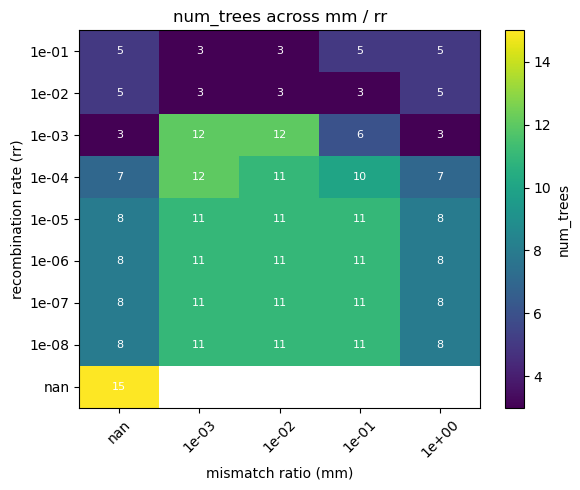

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = counts.copy()

# replace NAs with string
df["rr"] = df["rate"].astype(float)
df["mm"] = df["mm"].apply(lambda x: "nan" if pd.isna(x) else float(x))

# rows = rr (Y), columns = mm (X)
pivot_trees = df.pivot(index="rr", columns="mm", values="num_trees")

# sort axes so NAs are first 
cols = pivot_trees.columns.tolist()
cols_sorted = ["nan"] if "nan" in cols else []
cols_sorted += sorted([c for c in cols if c != "nan"], key=lambda x: float(x))
pivot_trees = pivot_trees[cols_sorted]
pivot_trees = pivot_trees.sort_index(ascending=False)

# plot heatmap
plt.figure(figsize=(6, 5))
im = plt.imshow(pivot_trees.values, aspect='auto', cmap='viridis')

# annotate cells with num_trees
for i in range(pivot_trees.shape[0]):
    for j in range(pivot_trees.shape[1]):
        val = pivot_trees.iloc[i, j]
        if not np.isnan(val):
            plt.text(j, i, int(val), ha='center', va='center', color='white', fontsize=8)

# colorbar and ticks
plt.colorbar(im, label='num_trees')
plt.xticks(
    range(len(pivot_trees.columns)),
    [str(c) if c == "nan" else f"{float(c):.0e}" for c in pivot_trees.columns],
    rotation=45
)
plt.yticks(
    range(len(pivot_trees.index)),
    [f"{float(y):.0e}" for y in pivot_trees.index]
)

# labeling
plt.xlabel('mismatch ratio (mm)')
plt.ylabel('recombination rate (rr)')
plt.title('num_trees across mm / rr')
plt.tight_layout()
plt.show()


#### Takeaways
-  Looks like recombination rates 1e-8 to 1e-5 produce accurate number of trees 
- mismatch ratio of 1 is most accurate (mm = NaN seems to default to 1, so the first and last cols are identical) 

## multivariate regression on pairwise MRCAs, weighted by interval overlap

Since simulated tree sequence has multiple trees, breakpoints don’t always align. I need to somehow score in consideration of the overlap between the inferred and simulated tree widths. Overall question: over what portion of the genome are a specific simulated and inferred tree simultaneously valid? 

- iterate over each inference run in res_list
- align simulated vs. inferred MRCA values by genomic interval intersection
- run weighted linear regression (weights = overlap length)
- compute summary metrics (r2, mae) 

In [26]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# df of regression summaries
results = []

# Loop over each inferred run
for df_inf in res_list: # keep track of rr, mm values 
    rr = df_inf['rr'].iloc[0]
    mm = df_inf['mm'].iloc[0]
    
    # comparison table with interval intersections
    comparison_rows = []
    for _, sim_row in sim_list.iterrows():
        # filter inference rows for same sample pair
        inf_sub = df_inf[(df_inf['sample_a'] == sim_row['sample_a']) &
                         (df_inf['sample_b'] == sim_row['sample_b'])]
        
        for _, inf_row in inf_sub.iterrows(): # get genomic coordinates 
            left = max(sim_row['left'], inf_row['left'])
            right = min(sim_row['right'], inf_row['right'])
            if left < right:
                weight = right - left
                comparison_rows.append({
                    'sample_a': sim_row['sample_a'],
                    'sample_b': sim_row['sample_b'],
                    'sim_tree': sim_row['index'],
                    'inf_tree': inf_row['index'],
                    'mrca_sim': sim_row['mrca'],
                    'mrca_inf': inf_row['mrca'],
                    'weight': weight
                })

    comp_df = pd.DataFrame(comparison_rows)

    # Run weighted regression
    X = comp_df['mrca_inf'].values.reshape(-1, 1)
    y = comp_df['mrca_sim'].values
    w = comp_df['weight'].values

    model = LinearRegression()
    model.fit(X, y, sample_weight=w)
    y_pred = model.predict(X)

    # Compute metrics
    mae = mean_absolute_error(y, y_pred, sample_weight=w)
    r2 = r2_score(y, y_pred, sample_weight=w)
    slope = model.coef_[0]
    intercept = model.intercept_

    results.append({
        'rr': rr,
        'mm': mm,
        'mae': mae,
        'r2': r2,
        'slope': slope,
        'intercept': intercept,
        'n_comparisons': len(comp_df)
    })

# Compile summary
summary_df = pd.DataFrame(results)

In [27]:
summary_df

,rr,mm,mae,r2,slope,intercept,n_comparisons
0,1e-08,0.001,0.038846,0.980821,1.009844,-0.016872,4200
1,1e-08,0.01,0.038846,0.980821,1.009844,-0.016872,4200
2,1e-08,0.1,0.038846,0.980821,1.009844,-0.016872,4200
3,1e-08,1.0,0.038058,0.981905,1.006262,-0.016074,3300
4,1e-08,nan,0.038058,0.981905,1.006262,-0.016074,3300
5,1e-07,0.001,0.038846,0.980821,1.009844,-0.016872,4200
6,1e-07,0.01,0.038846,0.980821,1.009844,-0.016872,4200
7,1e-07,0.1,0.038846,0.980821,1.009844,-0.016872,4200
8,1e-07,1.0,0.038058,0.981905,1.006262,-0.016074,3300
9,1e-07,nan,0.038058,0.981905,1.006262,-0.016074,3300


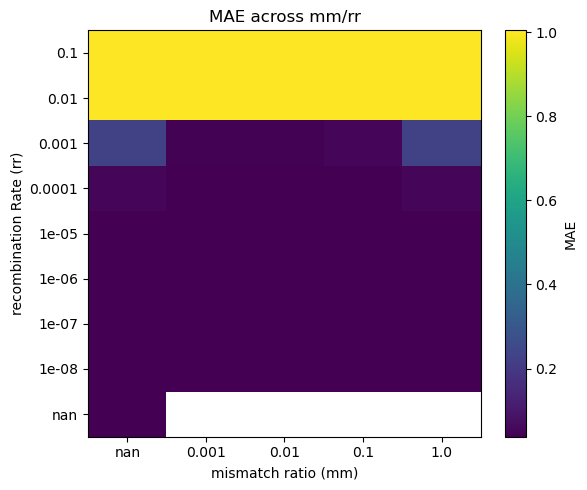

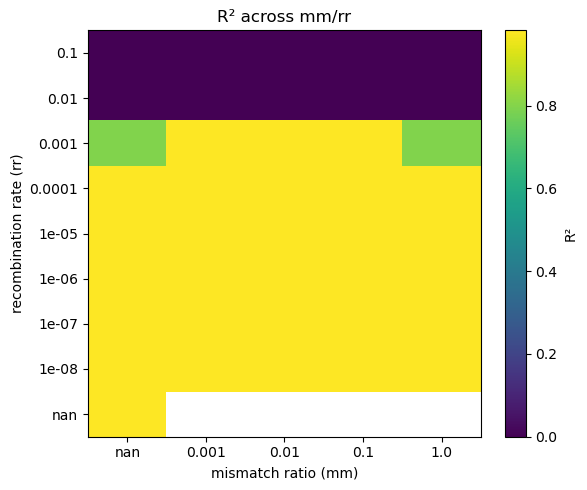

In [28]:
df = summary_df.copy()

# Convert parameters to numeric for plotting
df['rr'] = df['rr'].astype(float)
df['mm'] = df['mm'].astype(float)

# Pivot for MAE heatmap
pivot_mae = df.pivot(index='rr', columns='mm', values='mae').sort_index(ascending=False)

plt.figure(figsize=(6, 5))
plt.imshow(pivot_mae.values, aspect='auto')
plt.colorbar(label='MAE')
plt.xticks(range(len(pivot_mae.columns)), pivot_mae.columns)
plt.yticks(range(len(pivot_mae.index)), pivot_mae.index)
plt.xlabel('mismatch ratio (mm)')
plt.ylabel('recombination Rate (rr)')
plt.title('MAE across mm/rr')
plt.tight_layout()
plt.show()

# Pivot for R² heatmap
pivot_r2 = df.pivot(index='rr', columns='mm', values='r2').sort_index(ascending=False)

plt.figure(figsize=(6, 5))
plt.imshow(pivot_r2.values, aspect='auto')
plt.colorbar(label='R²')
plt.xticks(range(len(pivot_r2.columns)), pivot_r2.columns)
plt.yticks(range(len(pivot_r2.index)), pivot_r2.index)
plt.xlabel('mismatch ratio (mm)')
plt.ylabel('recombination rate (rr)')
plt.title('R² across mm/rr')
plt.tight_layout()
plt.show()


#### Takeaways: 
- Pretty good scores (low MAE, high R2) across a range of recombination rates around simulation value (1e-6) 
- default mismatch ratio 1.0 works reasonably well
- not sure if this is the best solution for comparing tree sequences with different structures. here i've evaluated accuracy in terms of how much of the genome is explained, not number of trees.
- most accurate number of trees falls upon the region w best R2/MAE scores 